# testing_classifiers

In [237]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

import pandas as pd
import connect_aws_db as cadb


In [137]:
%matplotlib inline

In [18]:
engine = cadb.connect_aws_db(write_unicode=True)

In [19]:
categories = ['dogs', 'general']

### Restore BF Reviews and Ratings

In [20]:
cmd = "SELECT review_rating, review_text FROM bf_reviews"

In [21]:
bfdf = pd.read_sql_query(cmd, engine)

In [22]:
print(len(bfdf))
bfdf.head(5)

1750


,review_rating,review_text
0,2,When you first go to your room you notice the ...
1,2,We were going to the Pre-Westminster event tha...
2,2,While the room was not the fanciest that one c...
3,1,I stayed at the Hotel Penn in Manhattan becaus...
4,5,We loved this hotel! The are very friendly and...


### Restore Yelp Reviews and Ratings

In [23]:
cmd = "SELECT review_rating, review_text FROM yelp_reviews"

In [24]:
yelpdf = pd.read_sql_query(cmd, engine)

In [25]:
print(len(yelpdf))
yelpdf.head(5)

6263


,review_rating,review_text
0,4,I stayed at the hotel for several months durin...
1,5,I have been coming to Pittsburgh for quite a w...
2,4,This is a very good hotel and with a corporate...
3,4,"i got upgraded to a junior suite, and then aga..."
4,5,This is a fantastic hotel. I went to a conven...


### Create a training and test data sets

In [55]:
train_data = np.hstack((bfdf['review_text'].values[:1000],
                        yelpdf['review_text'].values[:1000]))

In [59]:
len(train_data)

2000

In [73]:
labels = ['dog'] * 1000
labels.extend(['general'] * 1000)

In [74]:
len(labels)

2000

In [68]:
y_train = labels

In [57]:
test_data = np.hstack((bfdf['review_text'].values[1000:],
                       yelpdf['review_text'].values[1000:1750]))

In [58]:
len(test_data)

1500

In [75]:
labels = ['dog'] * 750
labels.extend(['general'] * 750)

In [76]:
y_test = labels

In [77]:
len(y_test)

1500

In [108]:
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                             stop_words='english')
X_train = vectorizer.fit_transform(train_data)
duration = time() - t0
print('vectorized in {:.2f} seconds.'.format(duration))

vectorized in 0.31 seconds.


In [109]:
t0 = time()
X_test = vectorizer.transform(test_data)
duration = time() - t0
print('transformed test data in {:.2f} seconds.'.format(duration))

transformed test data in 0.17 seconds.


In [61]:
feature_names = np.asarray(vectorizer.get_feature_names())

### Try RidgeClassifier

In [82]:
clf = RidgeClassifier(tol=1e-2, solver="lsqr")

In [83]:
print(clf)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='lsqr', tol=0.01)


In [84]:
clf.fit(X_train, y_train)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='lsqr', tol=0.01)

In [85]:
pred = clf.predict(X_test)

In [93]:
score = metrics.f1_score(y_test, pred, labels=None, pos_label=None)

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [92]:
len(y_test) == len(pred)

True

In [114]:
#help(metrics.f1_score)

### Now benchmark multiple classifiers

In [246]:
def benchmark(clf, pos_label=None):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.f1_score(y_test, pred, pos_label=pos_label)
    print("f1-score:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

#         if opts.print_top10 and feature_names is not None:
#             print("top 10 keywords per class:")
#             for i, category in enumerate(categories):
#                 top10 = np.argsort(clf.coef_[i])[-10:]
#                 print(trim("%s: %s"
#                       % (category, " ".join(feature_names[top10]))))
        print()

#     if opts.print_report:
#         print("classification report:")
#         print(metrics.classification_report(y_test, pred,
#                                             target_names=categories))

#     if opts.print_cm:
#         print("confusion matrix:")
#         print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

In [271]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=10), 'RandomForest')):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, solver='lsqr', tol=0.01)
train time: 0.007s
test time:  0.000s
f1-score:   0.909
dimensionality: 10427
density: 1.000000
()
()
Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.011s
test time:  0.000s
f1-score:   0.883
dimensionality: 10427
density: 0.409514
()
()
Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, fit_intercept=True, loss='hinge',
              n_iter=50, n_jobs=1, random_state=None, shuffle=True,
            

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".


f1-score:   0.823
()
RandomForest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 0.141s
test time:  0.006s
f1-score:   0.822
()


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [272]:
results

[('RidgeClassifier',
  0.90860488356795865,
  0.0066318511962890625,
  0.0002579689025878906),
 ('Perceptron',
  0.88330589725317643,
  0.010598897933959961,
  0.0003349781036376953),
 ('PassiveAggressiveClassifier',
  0.89463501034088466,
  0.014035940170288086,
  0.00027489662170410156),
 ('KNeighborsClassifier',
  0.82288265602726018,
  0.0015408992767333984,
  0.17803001403808594),
 ('RandomForestClassifier',
  0.82197552085036141,
  0.14136695861816406,
  0.005553007125854492)]

In [273]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))



L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.001, verbose=0)
train time: 0.013s
test time:  0.000s
f1-score:   0.911
dimensionality: 10427
density: 1.000000
()
()
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.013s
test time:  0.000s
f1-score:   0.896
dimensionality: 10427
density: 0.671238
()
()
L1 penalty
________________________________________________________________________________
Training: 
Li

/Applications/anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:192: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with mu


test time:  0.001s
f1-score:   0.898
dimensionality: 10427
density: 0.033087
()
()
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.065s
test time:  0.000s
f1-score:   0.885
dimensionality: 10427
density: 0.079985
()
()


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


In [274]:
results

[('RidgeClassifier',
  0.90860488356795865,
  0.0066318511962890625,
  0.0002579689025878906),
 ('Perceptron',
  0.88330589725317643,
  0.010598897933959961,
  0.0003349781036376953),
 ('PassiveAggressiveClassifier',
  0.89463501034088466,
  0.014035940170288086,
  0.00027489662170410156),
 ('KNeighborsClassifier',
  0.82288265602726018,
  0.0015408992767333984,
  0.17803001403808594),
 ('RandomForestClassifier',
  0.82197552085036141,
  0.14136695861816406,
  0.005553007125854492),
 ('LinearSVC',
  0.91131910497639845,
  0.013329029083251953,
  0.0003399848937988281),
 ('SGDClassifier',
  0.89599704169363048,
  0.01250600814819336,
  0.00034618377685546875),
 ('LinearSVC', 0.89798363204051856, 0.0238339900970459, 0.0006129741668701172),
 ('SGDClassifier',
  0.88533312948111897,
  0.0646810531616211,
  0.0003159046173095703)]

In [275]:
# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))


Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.068s
test time:  0.000s
f1-score:   0.892
dimensionality: 10427
density: 0.394936
()
()
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.004s
test time:  0.001s
f1-score:   0.902
()
Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.006s
test time:  0.001s
f1-score:   0.873
dimensiona

/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

In [276]:
results

[('RidgeClassifier',
  0.90860488356795865,
  0.0066318511962890625,
  0.0002579689025878906),
 ('Perceptron',
  0.88330589725317643,
  0.010598897933959961,
  0.0003349781036376953),
 ('PassiveAggressiveClassifier',
  0.89463501034088466,
  0.014035940170288086,
  0.00027489662170410156),
 ('KNeighborsClassifier',
  0.82288265602726018,
  0.0015408992767333984,
  0.17803001403808594),
 ('RandomForestClassifier',
  0.82197552085036141,
  0.14136695861816406,
  0.005553007125854492),
 ('LinearSVC',
  0.91131910497639845,
  0.013329029083251953,
  0.0003399848937988281),
 ('SGDClassifier',
  0.89599704169363048,
  0.01250600814819336,
  0.00034618377685546875),
 ('LinearSVC', 0.89798363204051856, 0.0238339900970459, 0.0006129741668701172),
 ('SGDClassifier',
  0.88533312948111897,
  0.0646810531616211,
  0.0003159046173095703),
 ('SGDClassifier',
  0.89199519978665709,
  0.06798696517944336,
  0.0003228187561035156),
 ('NearestCentroid',
  0.90183766130565257,
  0.0042188167572021484,
  

In [277]:
class L1LinearSVC(LinearSVC):

    def fit(self, X, y):
        # The smaller C, the stronger the regularization.
        # The more regularization, the more sparsity.
        self.transformer_ = LinearSVC(penalty="l1",
                                      dual=False, tol=1e-3)
        X = self.transformer_.fit_transform(X, y)
        return LinearSVC.fit(self, X, y)

    def predict(self, X):
        X = self.transformer_.transform(X)
        return LinearSVC.predict(self, X)

print('=' * 80)
print("LinearSVC with L1-based feature selection")
results.append(benchmark(L1LinearSVC()))


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
L1LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0)
train time: 0.037s
test time:  0.002s
f1-score:   0.904
dimensionality: 345
density: 1.000000
()
()


/Applications/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


### Plot Results

In [278]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

In [279]:
clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

In [280]:
clf_names

['RidgeClassifier',
 'Perceptron',
 'PassiveAggressiveClassifier',
 'KNeighborsClassifier',
 'RandomForestClassifier',
 'LinearSVC',
 'SGDClassifier',
 'LinearSVC',
 'SGDClassifier',
 'SGDClassifier',
 'NearestCentroid',
 'MultinomialNB',
 'BernoulliNB',
 'L1LinearSVC']

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


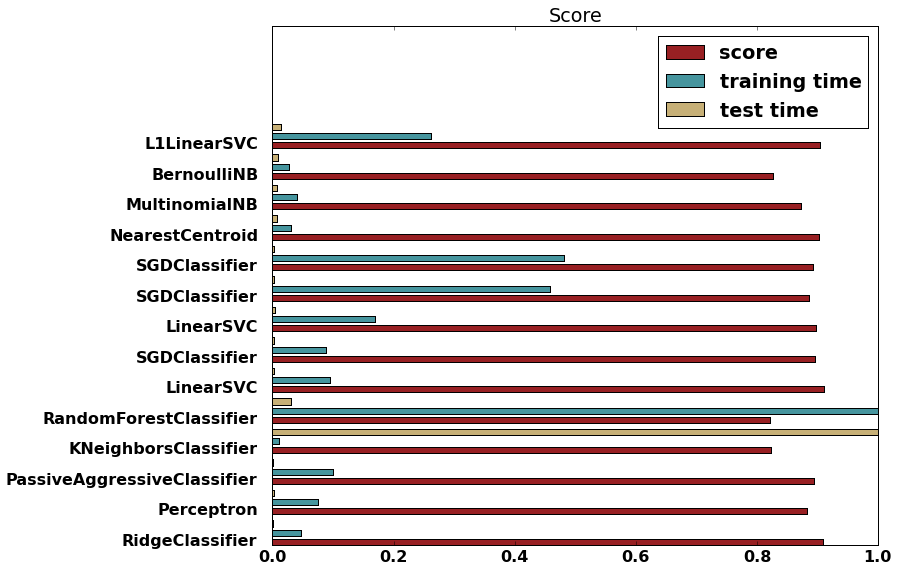

In [281]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 12.94, 8

#plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='#982023')
plt.barh(indices + .3, training_time, .2, label="training time", color='#46959E')
plt.barh(indices + .6, test_time, .2, label="test time", color='#C7B077')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
plt.ylim(0, 17)
print(indices)
for i, c in zip(indices, clf_names):
    plt.text(-0.025, i, c, horizontalalignment='right')

In [282]:
clf_names

['RidgeClassifier',
 'Perceptron',
 'PassiveAggressiveClassifier',
 'KNeighborsClassifier',
 'RandomForestClassifier',
 'LinearSVC',
 'SGDClassifier',
 'LinearSVC',
 'SGDClassifier',
 'SGDClassifier',
 'NearestCentroid',
 'MultinomialNB',
 'BernoulliNB',
 'L1LinearSVC']

In [285]:
clf_names[0] = 'Ridge'
clf_names[2] = 'PassAggress'
clf_names[3] = 'KNN'
clf_names[4] = 'RandomForest'
clf_names[5] = 'LinearSVC L2'
clf_names[6] = 'SGDC SVM L2'
clf_names[7] = 'LinearSVC L1'
clf_names[8] = 'SGDC L1'
clf_names[9] = 'SGDC ElNet'
clf_names[13] = 'LinearSVC L1FS'


14
14


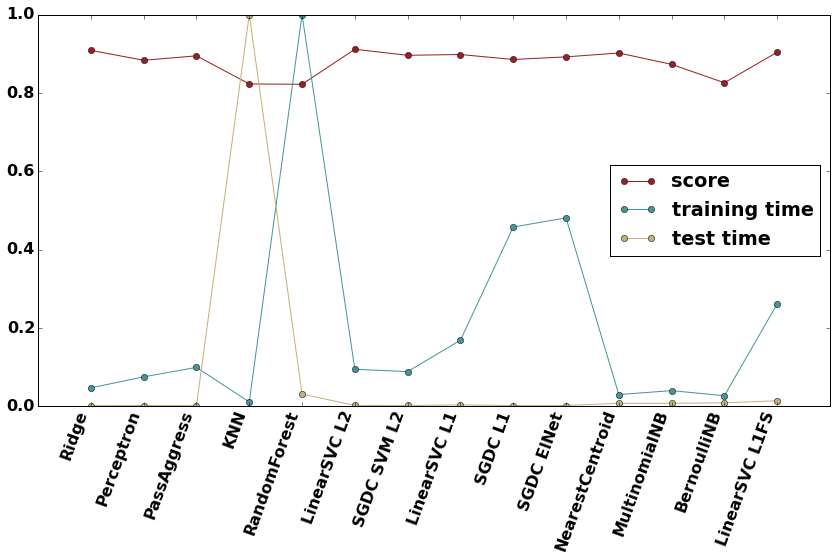

In [286]:
fig, ax = plt.subplots(1, 1)

training_timen = np.array(training_time) / np.max(training_time)
test_timen = np.array(test_time) / np.max(test_time)

ax.plot(indices, score, '-o', label="score", color='#982023')
ax.plot(indices, training_timen, '-o', label="training time", color='#46959E')
ax.plot(indices, test_timen, '-o', label="test time", color='#C7B077')
#labels = [item.get_text() for item in ax.get_xticklabels()]
print(len(labels))
print(len(clf_names))
labels = clf_names
ax.xaxis.set_ticks(np.arange(np.min(indices), np.max(indices)+1, 1))
ax.set_xticklabels(clf_names, rotation='70', horizontalalignment='right')
ax.set_xlim([-1, 14])
ax.set_ylim([0, 1])
ax.legend(loc='best')
plt.subplots_adjust(left=0.05, bottom=0.3, top=.98)
plt.savefig('classifierScoresNorm.png', dpi=144)

14
14


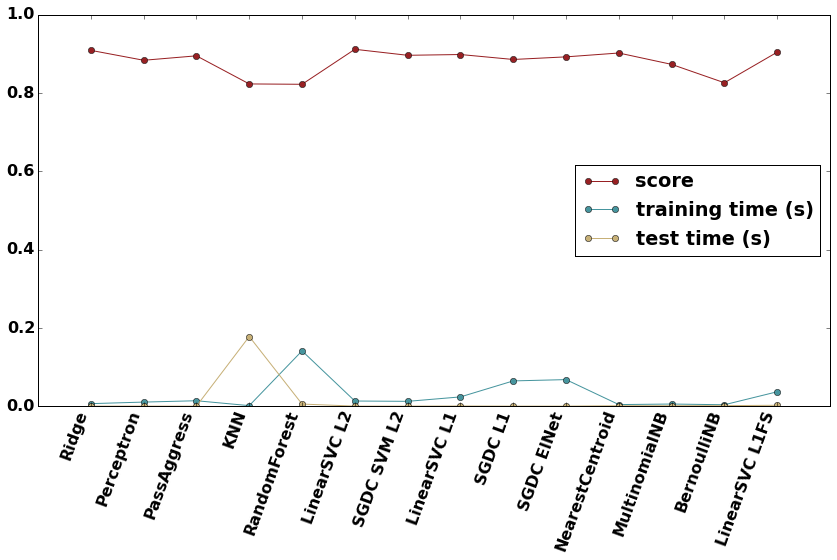

In [289]:
fig, ax = plt.subplots(1, 1)

clf_names, score, training_time, test_time = results

ax.plot(indices, score, '-o', label="score", color='#982023')
ax.plot(indices, training_time, '-o', label="training time (s)", color='#46959E')
ax.plot(indices, test_time, '-o', label="test time (s)", color='#C7B077')
#labels = [item.get_text() for item in ax.get_xticklabels()]
print(len(labels))
print(len(clf_names))
labels = clf_names
ax.xaxis.set_ticks(np.arange(np.min(indices), np.max(indices)+1, 1))
ax.set_xticklabels(clf_names, rotation='70', horizontalalignment='right')
ax.set_xlim([-1, 14])
ax.set_ylim([0, 1])
ax.legend(loc='best')
plt.subplots_adjust(left=0.05, bottom=0.3, top=.98)
plt.savefig('classifierScores.png', dpi=144)

In [288]:
for name, scr in zip(clf_names, score):
    print('{}: {:.3f}'.format(name, scr))

Ridge: 0.909
Perceptron: 0.883
PassAggress: 0.895
KNN: 0.823
RandomForest: 0.822
LinearSVC L2: 0.911
SGDC SVM L2: 0.896
LinearSVC L1: 0.898
SGDC L1: 0.885
SGDC ElNet: 0.892
NearestCentroid: 0.902
MultinomialNB: 0.873
BernoulliNB: 0.826
LinearSVC L1FS: 0.904


### Conclusions

All classifiers tested resulted in approximately the same score, and all had negligible training and testing time. The Linear SVC Classifier with L1 Penalization was the top-performer, so I'll go with that.